# Power Laws: Detecting Anomalies in Usage
Energy consumption of buildings has steadily increased. There is an increasing realization that many buildings do not perform as intended by their designers. Typical buildings consume 20% more energy than necessary due to faulty construction, malfunctioning equipment, incorrectly configured control systems and inappropriate operating procedures.

The building systems may fail to meet the performance expectations due to various faults. Poorly maintained, degraded, and improperly controlled equipment wastes an estimated 15% to 30% of energy used in commercial buildings.

Therefore, it is of great potential to develop automatic, quick-responding, accurate and reliable fault detection and to provide diagnosis schemes to ensure the optimal operations of systems to save energy.

Schneider Electric already has relevant offers, but would like to determine if alternative techniques can add new detections / functionalities, bring gain in precision, or operate with less data.

https://search.library.northwestern.edu/primo-explore/fulldisplay?docid=01NWU_HATHI_TRUSTMIU01-100664356&context=L&vid=NULVNEW&search_scope=NWU&tab=default_tab&lang=en_US

In [1]:
import pandas as pd
import numpy as np
import power_utils

%matplotlib inline

In [2]:
train = pd.read_csv('./tmp/train_prepared.csv')

D:\Anaconda3\envs\Automation-env\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
predictions = pd.read_csv('./output/Power_Laws_Diff_Gradient_Boosted_Trees_Regressor_(Least-Squares_Lo_(23)_0_subset_train_prepared.csv')

In [4]:
test = pd.read_csv('./input/submission_format.csv')

In [5]:
train['diff_preds_gbm'] = predictions['Prediction']

In [6]:
predictions = pd.read_csv('./output/Power_Laws_eXtreme_Gradient_Boosted_Trees_Regressor_with_Earl_(52)_0_Feature_Subset_train_prepared.csv')

In [7]:
train['value_preds_gbm'] = predictions['Prediction']

In [8]:
predictions = pd.read_csv('./output/Power_Laws_Diff_eXtreme_Gradient_Boosted_Trees_Regressor_with_Earl_(4)_0_subset_train_prepared.csv')

In [9]:
train['diff_preds_xgb'] = predictions['Prediction']

In [10]:
train_clean = train.drop_duplicates(['timestamp', 'meter_id'])

In [11]:
combined = pd.merge(train_clean, test, how='left', left_on=['timestamp', 'meter_id'], right_on=['Timestamp', 'meter_id'])

In [12]:
combined['is_abnormal'].value_counts()

False    402635
Name: is_abnormal, dtype: int64

In [13]:
test.shape

(402635, 4)

In [14]:
def absolute_difference(obs_val, pred_val):
    return np.absolute(pred_val - obs_val)

In [15]:
combined['abs_1'] = combined.apply(lambda r: absolute_difference(r['values'], r['value_preds_gbm']), axis=1)
combined = pd.merge(combined, combined.groupby('meter_id')['abs_1'].mean().reset_index(name='average_abs_1'), how='left', on='meter_id')
combined['anomaly_1'] = combined['abs_1']/combined['average_abs_1']
combined['anomaly_1'].describe()

count    5.950460e+05
mean     1.000000e+00
std      1.947059e+00
min      3.062411e-07
25%      4.372594e-02
50%      4.193790e-01
75%      1.210941e+00
max      9.555418e+01
Name: anomaly_1, dtype: float64

In [16]:
combined['abs_2'] = combined.apply(lambda r: absolute_difference(r['values_day_diff_7'], r['diff_preds_gbm']), axis=1)
combined = pd.merge(combined, combined.groupby('meter_id')['abs_2'].mean().reset_index(name='average_abs_2'), how='left', on='meter_id')
combined['anomaly_2'] = combined['abs_2']/combined['average_abs_2']
combined['anomaly_2'].describe()

count    587873.000000
mean          1.000000
std           0.952379
min           0.000008
25%           0.423958
50%           0.780054
75%           1.341621
max          14.965550
Name: anomaly_2, dtype: float64

In [17]:
combined['abs_3'] = combined.apply(lambda r: absolute_difference(r['values_day_diff_7'], r['diff_preds_xgb']), axis=1)
combined = pd.merge(combined, combined.groupby('meter_id')['abs_3'].mean().reset_index(name='average_abs_3'), how='left', on='meter_id')
combined['anomaly_3'] = combined['abs_3']/combined['average_abs_3']
combined['anomaly_3'].describe()

count    587873.000000
mean          1.000000
std           1.316315
min           0.000001
25%           0.376622
50%           0.741264
75%           1.213058
max         133.363931
Name: anomaly_3, dtype: float64

In [18]:
anomaly_1_cutoff = combined['anomaly_1'].quantile(q=0.8)
anomaly_2_cutoff = combined['anomaly_2'].quantile(q=0.8)
anomaly_3_cutoff = combined['anomaly_3'].quantile(q=0.8)

In [19]:
test_final = combined.dropna(subset=['is_abnormal'])

In [20]:
test_final.head()

,obs_id_x,meter_id,timestamp,values,site_id,meter_description,units,surface,activity,holiday,...,is_abnormal,abs_1,average_abs_1,anomaly_1,abs_2,average_abs_2,anomaly_2,abs_3,average_abs_3,anomaly_3
75014,1249814,234_203,2013-11-03 19:00:00,11.636,234_203,virtual main,kWh,5750.0,office,0,...,False,1160.204698,1141.564967,1.016328,NaN,1009.332595,NaN,NaN,2.643253,NaN
75015,1249815,234_203,2013-11-03 19:30:00,11.106,234_203,virtual main,kWh,5750.0,office,0,...,False,1266.852862,1141.564967,1.109751,NaN,1009.332595,NaN,NaN,2.643253,NaN
75016,1249816,234_203,2013-11-03 20:00:00,10.957,234_203,virtual main,kWh,5750.0,office,0,...,False,1267.001862,1141.564967,1.109882,NaN,1009.332595,NaN,NaN,2.643253,NaN
75017,1249817,234_203,2013-11-03 20:30:00,11.157,234_203,virtual main,kWh,5750.0,office,0,...,False,1383.265974,1141.564967,1.211728,NaN,1009.332595,NaN,NaN,2.643253,NaN
75018,1249818,234_203,2013-11-03 21:00:00,12.196,234_203,virtual main,kWh,5750.0,office,0,...,False,1382.226974,1141.564967,1.210818,NaN,1009.332595,NaN,NaN,2.643253,NaN


In [21]:
test_final['is_abnormal_1'] = test_final.apply(lambda r: True if r['anomaly_1'] > anomaly_1_cutoff else False, axis=1)
test_final['is_abnormal_2'] = test_final.apply(lambda r: True if r['anomaly_2'] > anomaly_2_cutoff else False, axis=1)
test_final['is_abnormal_3'] = test_final.apply(lambda r: True if r['anomaly_3'] > anomaly_3_cutoff else False, axis=1)

D:\Anaconda3\envs\Automation-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda3\envs\Automation-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda3\envs\Automation-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [22]:
test_final.dtypes

obs_id_x                        int64
meter_id                       object
timestamp                      object
values                        float64
site_id                        object
meter_description              object
units                          object
surface                       float64
activity                       object
holiday                         int64
temperature                   float64
distance                      float64
values_business_day_lag_1     float64
values_day_lag_1              float64
values_day_lag_7              float64
values_business_day_diff_1    float64
values_day_diff_1             float64
values_day_diff_7             float64
dow                             int64
wom                             int64
year                            int64
month                           int64
day                             int64
hour                            int64
minute                          int64
business_hours                  int64
evening     

In [23]:
test_final.is_abnormal_1.value_counts()

False    330437
True      72198
Name: is_abnormal_1, dtype: int64

In [24]:
test_scored = test_final[['obs_id_y', 'meter_id', 'Timestamp', 'is_abnormal_1']]

In [25]:
test_scored.columns = ['obs_id', 'meter_id', 'Timestamp', 'is_abnormal']

In [26]:
test_scored.to_csv('./output/test_scored1.csv', index=False)

In [27]:
test_scored = test_final[['obs_id_y', 'meter_id', 'Timestamp', 'is_abnormal_2']]
test_scored.columns = ['obs_id', 'meter_id', 'Timestamp', 'is_abnormal']
test_scored.to_csv('./output/test_scored2.csv', index=False)

In [28]:
import seaborn as sns

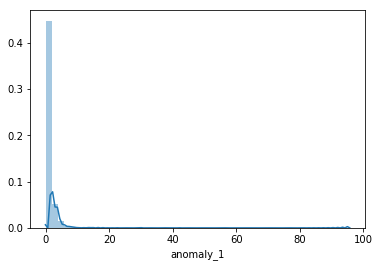

In [32]:
ax = sns.distplot(test_final['anomaly_1']);

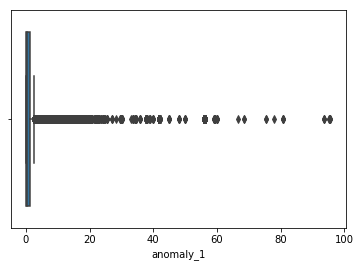

In [34]:
ax = sns.boxplot(x=test_final['anomaly_1']);

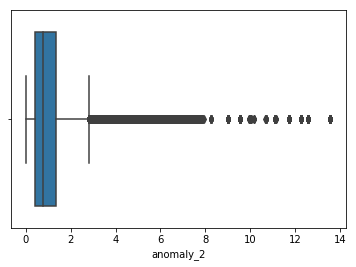

In [35]:
ax = sns.boxplot(x=test_final['anomaly_2']);

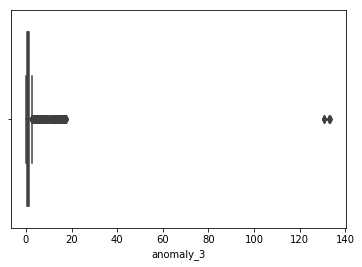

In [36]:
ax = sns.boxplot(x=test_final['anomaly_3']);

In [37]:
anomaly_2_80

1.5592216386294724